# Study of correlation in financial time series
Studying and understanding correlation, give us a powerful tool to analyze time series better. Whether you want to diversify your portfolio, optimize it, or hedge it(this would also require to understand beta hedging), correlation makes it easier and helps to avoid mistakes in the process. <br>
Here we will focus on recognizing similarities in time series and determining when these similarities have evolved. First, we need to set up a theoretical model to test our correlation against it. Then, moving on to a real example. Let's start:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from Functions import getdata, kalman
from statsmodels.tsa.stattools import adfuller
import scipy.stats as st

### Data model
We define our stock pricing model as a geometric Brownian motion. A stochastic process $S_t$ is said to follow a geometric brownian motion if it satisfies the following equation: 
$$\large dS_t=\mu S_tdt+\sigma S_tdt$$
where: 
$$\small \mu: \text{Drift of the brownian model}$$
$$\small \sigma: \text{Standard deviation of the Brownian model}$$
<br>The analytic solution can be expressed as:
$$\large S_t = S_0\cdot e^{(\mu-\frac{\sigma^2}{2})\cdot t + \sigma\cdot W_t}$$
where: 
$$\small W_t: \text{Is a vector of random samples with normal distribution, zero mean and standard deviation dt}$$
$$\small S_0: \text{First value of the serie}$$

In [2]:
def geometric_brownian_motion(start_date, end_date, mu = 0.1, sigma = 0.01, start_price = 20, nseries = 1):        
    dates = pd.bdate_range(start_date, end_date)
    days = dates.size
    years = days/252   #252 are the bussiness days in a year
    t = np.linspace(0,years,days)*np.ones((nseries, days))
    dt = years/days
    returns = np.random.normal(0,np.sqrt(dt),size = (nseries,days)) 
    cum_returns = np.cumsum(returns, axis = 1)
    norm_price_change = (mu-(sigma**2)/2) * t + sigma * cum_returns
    prices = start_price * np.exp(norm_price_change)
    names = ['Serie '+ str(index) for index in range(nseries)]
    #names = ['Serie '+ str(index)+' mean '+str(mu)+'std_dev '+str(sigma) for index in range(nseries)]
    return pd.DataFrame(prices.transpose(), index=dates , columns = names)

In [3]:
PORTFOLIO = geometric_brownian_motion(start_date = '2016-01-01', 
                                   end_date='2018-12-31', 
                                   mu = 0.1, 
                                   sigma = 0.05, 
                                   start_price = 20, 
                                   nseries = 4)

We can now plot the simulated portfolio. Depending on the chosen $\mu$ and $\sigma$ we can see different results but, at first sight, they look similar.

Text(0,0.5,'Price ($)')

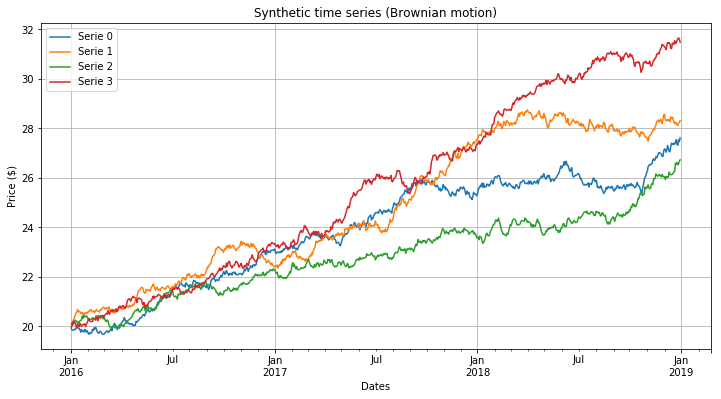

In [4]:
ax = PORTFOLIO.plot(figsize=[12,6], grid= True, title='Synthetic time series (Brownian motion)')
ax.set_xlabel('Dates')
ax.set_ylabel('Price ($)')

### Computing correlation
We are going to calculate the correlation among the assets in the portfolio. To do so, first, we get the returns of the assets. It is essential to use the percentage returns because otherwise, we will be taking into account the different level of the prices. One can also take the returns of the log price which also wipes the difference out.

          Serie 0   Serie 1   Serie 2   Serie 3
Serie 0  1.000000  0.020694 -0.032134  0.104586
Serie 1  0.020694  1.000000 -0.001601  0.023885
Serie 2 -0.032134 -0.001601  1.000000  0.014857
Serie 3  0.104586  0.023885  0.014857  1.000000


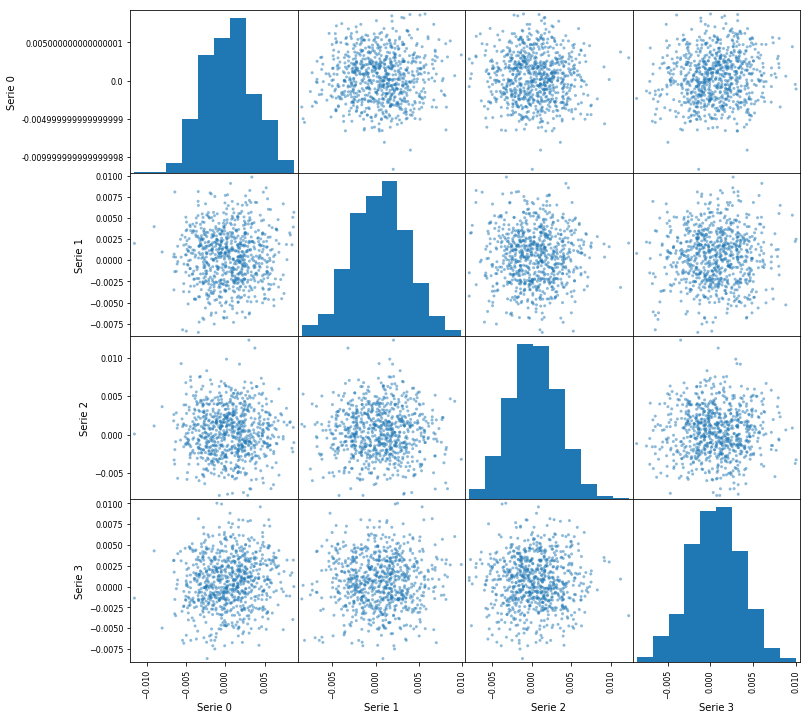

In [5]:
CORR = PORTFOLIO.pct_change().dropna().corr()
print(CORR)
pd.plotting.scatter_matrix(PORTFOLIO.pct_change().dropna(), figsize=(12, 12), diagonal='hist');

          Serie 0   Serie 1   Serie 2   Serie 3
Serie 0  1.000000  0.020591 -0.032141  0.104642
Serie 1  0.020591  1.000000 -0.001513  0.023877
Serie 2 -0.032141 -0.001513  1.000000  0.014946
Serie 3  0.104642  0.023877  0.014946  1.000000


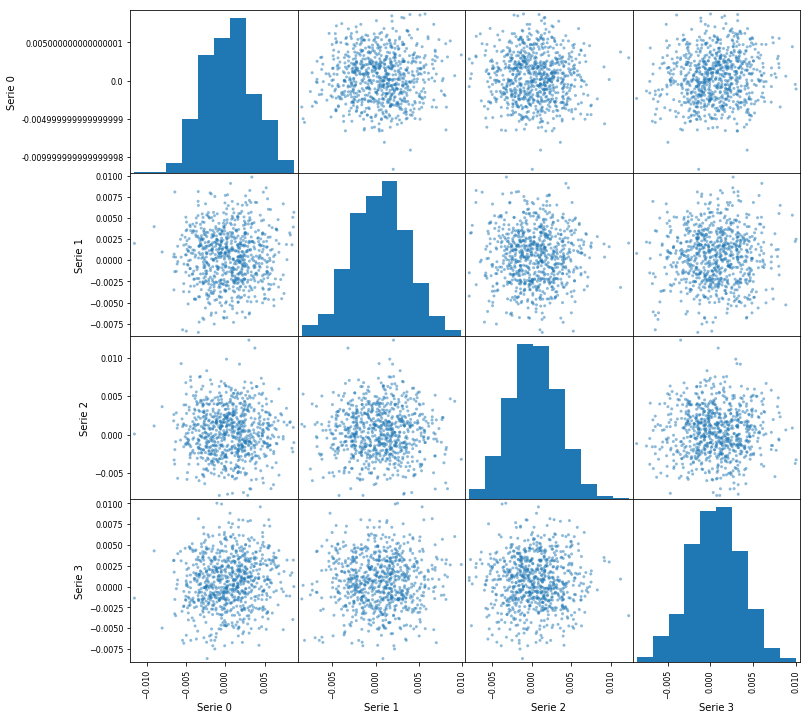

In [6]:
CORR = (np.log(PORTFOLIO)-np.log(PORTFOLIO.shift(-1))).dropna().corr()
print(CORR)
pd.plotting.scatter_matrix(PORTFOLIO.pct_change().dropna(), figsize=(12, 12), diagonal='hist');

As one would expect, there is no correlation among them because they were created out of a different (and random) set of [data](#Data-model). Nevertheless, they do share some statistics such as mean and std deviation, but **That does not mean they correlate**. That is why it is vital to take percentage changes (or returns of log prices) instead of raw prices. What if we took raw prices? 

          Serie 0   Serie 1   Serie 2   Serie 3
Serie 0  1.000000  0.940061  0.956396  0.938829
Serie 1  0.940061  1.000000  0.935077  0.969157
Serie 2  0.956396  0.935077  1.000000  0.960767
Serie 3  0.938829  0.969157  0.960767  1.000000


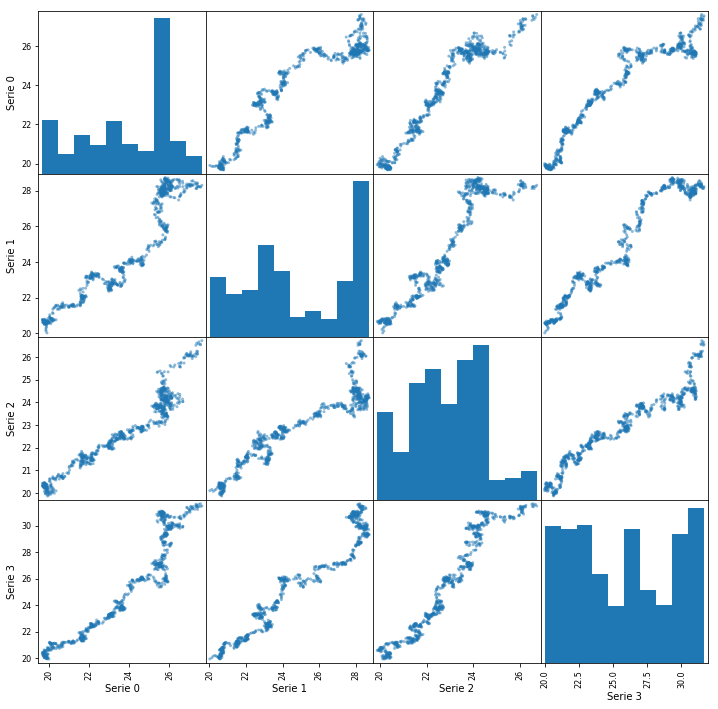

In [7]:
print(PORTFOLIO.corr())
pd.plotting.scatter_matrix(PORTFOLIO.dropna(), figsize=(12, 12), diagonal='hist');

The above would lead us to think they are correlated, but their returns are not. <br>
Nevertheless, if you are looking for the opposite, id est, diversifying your portfolio, you would have found [here](#Data-model) a great opportunity. Not correlated assets but positive returns on all of them.<br>
That is why it is important to know both the ultimate goal and how to calculate correlation properly.

## Real pricing example
However, one may wonder what would happen if we took a pair of real series that we all know they are correlated. We can pick the SPY 500 index ETF and NASDAQ index ETF

Text(0,0.5,'Price ($)')

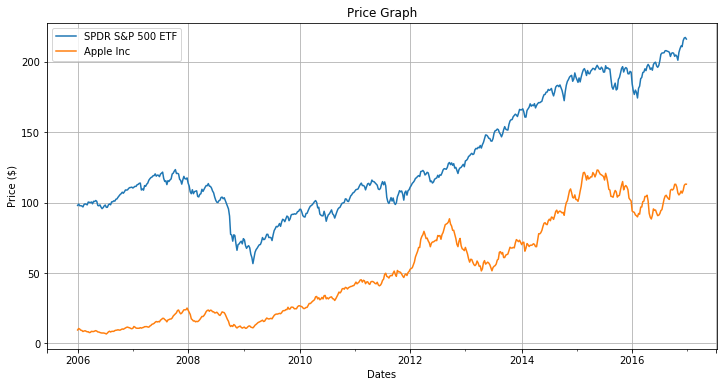

In [8]:
DS1 = getdata('SPY', '2006-01-01', '2016-12-31')
DS2 = getdata('QQQ', '2006-01-01', '2016-12-31')
COMB = pd.concat([DS1,DS2],axis = 1).resample('7d').mean()
ax=COMB.plot(figsize=[12,6], grid = True, title='Price Graph')
ax.set_xlabel('Dates')
ax.set_ylabel('Price ($)')

We know these two are fundamentally correlated. Let's see if numbers say the same.

                  SPDR S&P 500 ETF  Apple Inc
SPDR S&P 500 ETF          1.000000   0.581989
Apple Inc                 0.581989   1.000000


Text(0,0.5,'Apple Inc (% change)')

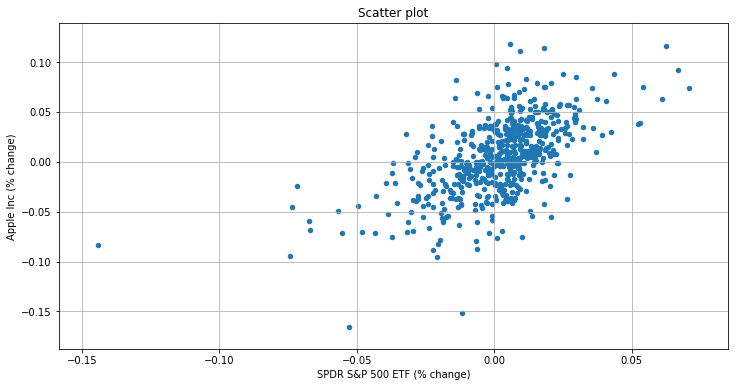

In [9]:
CORR = COMB.pct_change().dropna().corr()
print(CORR)
FirstAsset = COMB.columns.values[0]
SecondAsset = COMB.columns.values[1]
ax= COMB.pct_change().dropna().plot(kind = 'scatter', x=FirstAsset, y = SecondAsset, figsize=[12,6], grid = True, 
                                    title='Scatter plot')
ax.set_xlabel(FirstAsset+' (% change)')
ax.set_ylabel(SecondAsset+' (% change)')

Clearly, they arecorrelated.<br> The correlation coefficient is a very helpful statistic to build a diversified portfolio.
If wanting a well-diversified portfolio, one needs to introduce assets not correlated with each other and positive expected return. That will stretch the global equity curve, improving the risk-adjusted measure of it (Sharpe, Sortino, whatever you choose). That will ultimately help to overcome corrections of single assets or even market recessions.

### Stationarity test
The first step to understanding the correlation coefficient is to check whether it is stationary or not. To do that, we need to have successive correlation samples

Text(0,0.5,'Pearson correlation coefficient (r)')

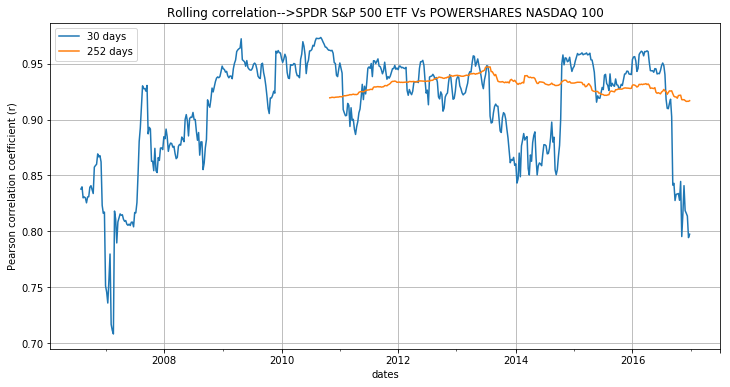

In [10]:
FirstAsset = COMB.columns.values[0]
SecondAsset = COMB.columns.values[1]
fast_window = 30
slow_window = 252
corr_fast = COMB.pct_change().dropna().rolling(fast_window).corr().unstack()[FirstAsset][SecondAsset]
corr_fast.name = str(fast_window)+' days'
corr_slow = COMB.pct_change().dropna().rolling(slow_window).corr().unstack()[FirstAsset][SecondAsset]
corr_slow.name = str(slow_window)+' days'
both_corr = pd.DataFrame([corr_fast, corr_slow]).transpose()
ax = both_corr.plot(figsize = [12,6], grid = True, 
                    title = 'Rolling correlation-->'+str(FirstAsset) +' Vs '+ str(SecondAsset))
ax.set_xlabel("dates")
ax.set_ylabel("Pearson correlation coefficient (r)")

Now, we can perform an Augmented Dickey-Fuller test:

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(corr_fast.dropna())
print('p-value: %f' % result[1])

p-value: 0.109863


We cannot reject the null hypothesis of the unit root in favor of the alternative, id est, the correlation coefficient is not stationary and thus their statistics (such as mean and standard deviation) change over time.<br>
So with that variation over time, one can think that has a diversified (uncorrelated) portfolio when actually has not. If you do not recheck correlations periodically, you could end up with a completely correlated portfolio.<br>
In the above figure, one can see the difference between choosing larger lookback periods. So one may ask, what period should be used? We want to calculate the real correlation coefficient, not the noisy output produced by the time series on a daily basis. That is why it is so helpful to have a suitable filter mechanism. The first one that comes into the mind is simply increasing the loopback period as it averages more samples and thus, produce smoother outputs. That effect can be seen above. The con of that approach is that we will be less responsive to a quick change in the dynamics because our lookback period is too long. So we have a tradeoff between quick response to data changes and smoothness of the signal. Some other authors propose a Kalman filter which is an adaptative filter. Nevertheless, the designer needs to model the covariance matrix of noises (Q & R), which is not a trivial process to do.
In this case, for the sake of simplicity, we will take a look back period of 30 days. Rolling correlations seem consistent in time so that we can perform a hypothesis testing. Later we will see that the size of the sample does not affect the decision regarding having an evolving correlation.

### Hypothesis testing
Since our mean & std deviation change over time we need to build a mechanism that detects when this change is statistically significative.<br>
Our random variable is the correlation parameter *r*, derived from the historical population of [prices](#Real-pricing-example). Then we are going to detect if future samples will come from the old population or they have evolved. The latter would mean that our entire study of correlation based on historical data is outdated and does not represent the current values we are obtaining. <br> To do that, let's visualize the histogram first.

Text(0.5,1,'Histogram of the population')

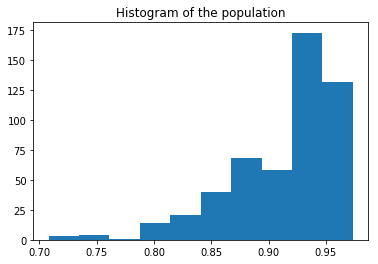

In [12]:
samples_per_mean = fast_window
population = corr_fast.dropna()[:-samples_per_mean]#this data is to 
sample = corr_fast.dropna()[-samples_per_mean:]#we reserve some data to test
plt.hist(population);
plt.title('Histogram of the population')

#### Fisher Transformation
As we can see, the histogram is highly skewed, far from being normally distributed. That is not good since we would like to see a nice bell-shaped histogram. Traditionally, one may apply a transformation to the input data so that the histogram is normal. It can be achieved using fisher transform $$Z = 0.5\cdot\frac{ln(1+r)}{ln(1-r)}$$ with Standard Error $ SE = \frac{1}{\sqrt{N-3}} $ where N is the number of samples

Text(0.5,1,'Histogram of the Fisher transformed population')

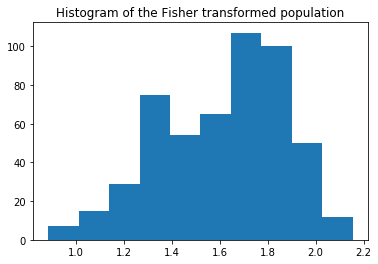

In [13]:
z = 0.5*np.log((1+population)/(1-population))
plt.hist(z.dropna());
plt.title('Histogram of the Fisher transformed population')

In [14]:
t, p = st.jarque_bera(z) #it checks if data is normally distributed or not
print('p value of normality test: %.4f'%p)

p value of normality test: 0.0000


At first sight, the Fisher transformed histogram seemed normal, but the normality test shows it is very unlikely to be true. Nevertheless, since the literature is very confident in Fisher transform, we are going to go ahead and continue exploring the possibilities. <br>
Now our problem reduces to check if new correlation data (Fisher transformed) comes from the above distribution. Since the distribution is normal, we only have to calculate the z-score for new data, and with the help of the z-table, checking the probability of occurrence of that value. <br>
For this test, we want a confidence interval of 99% so an alpha of 0.01. In a two-tailed test, our z-critical values would be:

In [15]:
alpha = 0.01
z_crit = st.norm.ppf(1-alpha/2)#two tailed test
print('critical value: %.3f' %z_crit)

critical value: 2.576


We are now able to calculate the z-score of the new data. Remember we had reserved a portion of the initial data for checking purposes. 

In [16]:
r = sample[0]
z_sample = 0.5*np.log((1+r)/(1-r))
std_err = 1/np.sqrt(fast_window-3)
z_score = (z_sample-z.mean())/std_err
print('Correlation value: %.4f'%r)
print('z_score value: %.4f' %abs(z_score))
print('p-value: %.4f' %(1-st.norm.cdf(np.abs(z_score))))

Correlation value: 0.9408
z_score value: 0.6870
p-value: 0.2460


Now we are confident that our data comes from the same population, so we can keep trusting our trading schema. Nevertheless, what would happen if we get a correlation slightly smaller than the mean, let's say 0.85:

In [17]:
r = .85
z_sample = 0.5*np.log((1+r)/(1-r))
std_err = 1/np.sqrt(fast_window-3)
z_score = (z_sample-z.mean())/std_err
print('z_score value: %.4f' %abs(z_score))
print('p-value: %.4f' %(1-st.norm.cdf(np.abs(z_score))))

z_score value: 1.8533
p-value: 0.0319


### A bunch of samples
We still think that our new data comes from the modeled distribution. However, what if not only one, but twenty-five 0.85 correlations came in a row? Would the model still hold? With the Fisher transform we will obtain:

In [18]:
r = np.asarray([.85]*samples_per_mean)
z_sample = 0.5*np.log((1+r)/(1-r))
std_err = 1/np.sqrt(fast_window-3)
z_score = (z_sample-z.mean())/std_err
print('z_score values:' + str(z_score))
print('p-values: '+ str((1-st.norm.cdf(np.abs(z_score)))))

z_score values:[-1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713
 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713
 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713
 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713
 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713 -1.85334713]
p-values: [0.03191631 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631
 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631
 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631
 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631
 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631 0.03191631]


Twenty-five consecutive values below the mean seem quite strange just at first sight, but our Fisher transformation does not consider that. It just looks at every sample independently.

Finally, if we got a correlation smaller than the mean, let's say 0.8:

In [19]:
r = .8
z_sample = 0.5*np.log((1+r)/(1-r))
std_err = 1/np.sqrt(fast_window-3)
z_score = (z_sample-z.mean())/std_err
print('Correlation value: %.4f'%r)
print('z_score value: %.4f' %abs(z_score))
print('p-value: %.4f' %(1-st.norm.cdf(np.abs(z_score))))

Correlation value: 0.8000
z_score value: 2.6720
p-value: 0.0038


That would mean that our new correlation between time series is significantly different from the previous ones. That is a red flag that needs to be evaluated in order to keep taking into account correlation in our trading model.<br>
Summarizing the above approach, if we got a correlation level of 0.8 the test would say the sample does not come from the studied population. For the same reason, if we got 25 correlations in a row of r= 0.85, we could not reject the null hypothesis. That is why the above test seems to work on individual samples, but when you take a bunch of samples, the results may be misleading.

#### Box Cox Transformation
Another popular transformation is the Box Cox algorithm. It tries to convert a non-normal distribution in a normal one. To do that it analyzes the data and tries to estimate the transformation factor $\lambda$ that better fits a normal distribution.<br> Once you have the right $\lambda$, the transformation goes as follows:
$$ 
x'=\begin{cases}
    \frac{x^\lambda -1}{\lambda} & \text{if $\lambda \neq 0$}.\\
    log(x) & \text{if $\lambda = 0$}.
  \end{cases} $$

p value of normality test: 0.0000


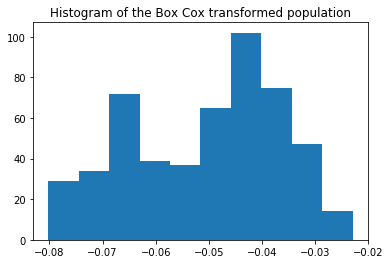

In [21]:
bc, maxlog, interval = st.boxcox(population, alpha=.005)
plt.hist(bc);
plt.title('Histogram of the Box Cox transformed population')
t, p = st.jarque_bera(bc);
print('p value of normality test: %.4f'%p)

As we can see above, the new histogram is far from being normal as both visual inspection and Jarque-Bera test show.

#### Sample means test
What we are going to do next is pretending we do not know about Fisher nor Cox Box transformations. However, remember we had a skewed distribution, so how do we normalize it? According to the central limit theorem (CLT), the distribution of sample means becomes normal as the number of samples increases. This normal distribution has mean  $M \approx \mu$ and a standard error $SE=\dfrac{\sigma}{\sqrt{n}}$. 
  So, the population mean would be simply the sample mean and standard deviation $s = SE\cdot\sqrt{n}\approx \sigma$ 
To solve that, one can repeat the above exercise but taking the sample means instead of the samples.

In [22]:
sample_means = population.rolling(samples_per_mean).mean().dropna()
M = sample_means.mean()
SE = sample_means.std()
print('M: %.4f, Population mu : %.4f, Population Sigma: %.4f' %(M, population.mean(), population.std()))
print('SE: %.4f'%SE)

M: 0.9150, Population mu : 0.9137, Population Sigma: 0.0469
SE: 0.0399


Text(0.5,1,'Histogram of the sample means picked as they come')

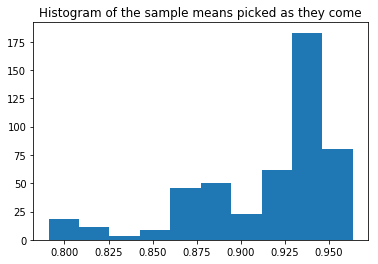

In [23]:
plt.hist(sample_means);
plt.title('Histogram of the sample means picked as they come')

What happened with the normal histogram we were expecting? Didn't the CLT work at all? The CLT assumes that we **randomly** pick samples to obtain sample distribution. Nevertheless, our dataset is very special because the correlation coefficient moves in clusters. That means that if we take 20 consecutive values, it is likely they are a very close one to each other. The only way we can generate a normal sample distribution is if we performed the following:

Mean: 0.9141
SE: 0.0080
Estimated Population Sigma: 0.0436, real population sigma 0.047
p value of normality test: 0.6965


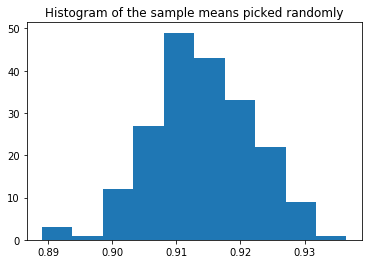

In [24]:
sample_means = np.random.choice(population, (samples_per_mean,200), replace = True).mean(axis=0)
plt.hist(sample_means)
plt.title('Histogram of the sample means picked randomly')
print('Mean: %.4f'%sample_means.mean())
print('SE: %.4f'%sample_means.std())
sigma = np.sqrt(samples_per_mean)*sample_means.std()
print('Estimated Population Sigma: %.4f, real population sigma %.3f'%(sigma, population.std()))
t, p = st.jarque_bera(sample_means) 
print('p value of normality test: %.4f'%p)

We can now see how the CLT applies. Nevertheless, although the normality test could not reject the null hypothesis, we cannot take random samples on a real data feed basis, since they will inevitably come in clusters as in previous plots.

#### Custom histogram estimation
Since our previous attempts to fit the data to a normal distribution have failed, we have to deal with our skewed distribution. We can fit a custom histogram based on a Gaussian kernel estimation. Once we have that, we can easily find the critical values for our previously defined alpha level of 0.01.

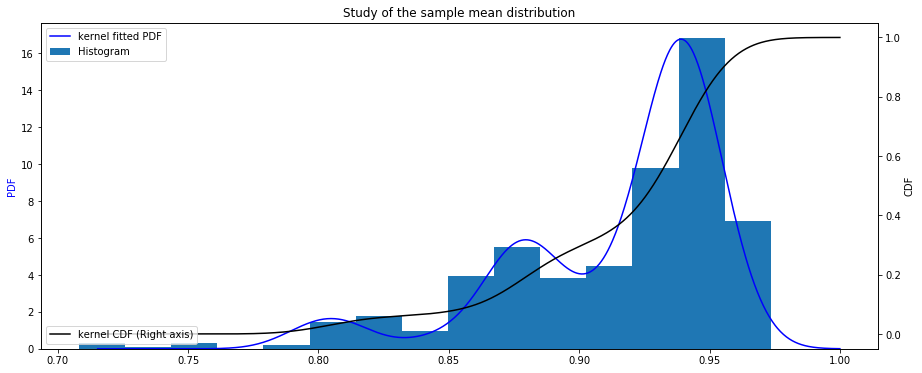

In [25]:
sample_means = population.rolling(samples_per_mean).mean().dropna()
M = sample_means.mean()
SE = sample_means.std()
x = np.linspace(M-5*SE, 1, 1000)
kernel = st.gaussian_kde(sample_means)
pdf_kernel = kernel.pdf(x)
cdf_kernel = np.cumsum(pdf_kernel)*(x[1]-x[0])
fig, ax1 = plt.subplots(figsize = [15,6])
plt.title('Study of the sample mean distribution')
plt.hist(population, density=True, bins=15, label='Histogram');
ax1.plot(x, pdf_kernel, label='kernel fitted PDF', color = 'b')
ax2 = ax1.twinx()
ax2.plot(x, cdf_kernel, label='kernel CDF (Right axis)', color = 'k')
ax1.set_ylabel('PDF', color='b')
ax2.set_ylabel('CDF', color='k')
leg = ax1.legend(loc = 'upper left');
leg2 = ax2.legend(loc = 'lower left');

We can see a nice fitted probability density function (PDF) and its cumulative distribution function (CDF). We can find the critical values now, but unlike before, critical values are now absolute. That means it does not make sense normalize them to $z_{crit}=(r-\mu)/\sigma$ since the PDF cannot be regenerated without the original data and $z_{crit}$ is not symmetrical.

In [26]:
idx_crit = list(np.round(cdf_kernel, 3)).index(0.006)#(0.01/2)+delta since index function finds the first occurence
crit_low=x[idx_crit]
idx_crit = list(np.round(cdf_kernel, 3)).index(0.995)
crit_up=x[idx_crit]
crit = np.asarray([crit_low, crit_up])
print('crit values: ' +str(crit))

crit values: [0.78514018 0.97691824]


Since the above PDF has been generated from a sample means, it accounts for correlation values coming in clusters, so the decision whether a bunch of correlation samples comes from the studied distribution is more precise. Also, increasing the sample size does not give you any significant advantage in identifying a change in the dynamics of prices.

## Conclussion
During this post we have learned that in order to have a valid understanding of the [correlation](#Computing-correlation) of two or more assets we need to use either log returns $LR_i = log(p_i)-log(p_{i-1})$ or percentage returns $PR_i = \frac{p_i}{p_{i-1}}-1$<br>
Then, the resulting Pearson correlation coefficient [is not stationary](#Stationarity-test), so its mean and standard deviation change over time. It means that we have to deal with changing values and a complete histogram study need to be done.
The shape of the correlation samples distribution is not normal due to its skewness and kurtosis. Neither the [Fisher transformation](#Fisher-Transformation) nor the [Box Cox transformation](#Box-Cox-Transformation) have succeeded in normalizing that histogram. Applying the [Central Limit Theorem](#Sample-means-test) did not help either since correlation samples are highly dependant on its nearest neighbors and they are not randomly picked.<br>
If we take correlation samples instead of correlation sample means, the [results are misleading](#A-bunch-of-samples)<br>
If we wanted to know if a determined group of correlation sample means come from a previously studied distribution, we need first to model that distribution with a [Gaussian kernel estimation](#Custom-histogram-estimation). Then calculating their critical values (asymmetric) for a determined critical value. Lastly, we have to compare the mean values of the new data with the previously calculated critical boundaries. This proccess is independent on the lookback period we happen to chose<br>
The conclusions depicted in this post should be the foundation for any trading system or study based on correlation among assets. Hope it helped.

Julio García